In [199]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import sqrt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display

In [200]:

ant_pos = []
for i in range(nant):
    x = torch.rand(1).item() * max_baseline
    y = torch.rand(1).item() * max_baseline
    ant_pos.append([x, y])

y1=ant_pos[0][1]
y2=ant_pos[1][1]
y3=ant_pos[2][1]
y4=ant_pos[3][1]

x1=ant_pos[0][0]
x2=ant_pos[1][0]
x3=ant_pos[2][0]
x4=ant_pos[3][0]

x0=torch.tensor(ant_pos[0][0])
y0=torch.tensor(ant_pos[0][1])
x1=torch.tensor(ant_pos[1][0])
y1=torch.tensor(ant_pos[1][1])
x2=torch.tensor(ant_pos[2][0])
y2=torch.tensor(ant_pos[2][1])
x3=torch.tensor(ant_pos[3][0])
y3=torch.tensor(ant_pos[3][1])

width = 256
max_baseline = 4.0
nant = 4
center_position=[128,128]


In [201]:
def compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3):
    
    b1=[(x0-x1),(y0-y1)]
    b2=[(x0-x2),(y0-y2)]
    b3=[(x0-x3),(y0-y3)]
    b4=[(x1-x0),(y1-y0)]
    b5=[(x1-x2),(y1-y2)]
    b6=[(x1-x3),(y1-y3)]
    b7=[(x2-x0),(y2-y0)]
    b8=[(x2-x1),(y2-y1)]
    b9=[(x2-x3),(y2-y3)]
    b10=[(x3-x0),(y3-y0)]  
    b11=[(x3-x1),(y3-y1)]
    b12=[(x3-x2),(y3-y2)]

    baselines_tensor = torch.stack([
        torch.tensor(b1), torch.tensor(b2), torch.tensor(b3),
        torch.tensor(b4), torch.tensor(b5), torch.tensor(b6),
        torch.tensor(b7), torch.tensor(b8), torch.tensor(b9),
        torch.tensor(b10), torch.tensor(b11), torch.tensor(b12)
    ])

    baselines_tensor.retain_grad
    
    return baselines_tensor


baselines=compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3)

In [202]:

optimizer = optim.SGD([x0, y0, x1, y1, x2,y2, x3, y3], lr=.1)

steps = 500

loss_history = []
# Optimization loop
for step in range(its):

    
    # Compute baselines
    baselines=compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3)

    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)

    u_indices = [
        int((baselines[0][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][0] + max_baseline) * width / (2 * max_baseline)),
    ]

    v_indices = [
        int((baselines[0][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][1] + max_baseline) * width / (2 * max_baseline)),
    ]



    # Creating a new tensor instead of in-place modification
    uv = uv.clone()
    #u_index = 5  # Example index
    #v_index = 5  # Example index

    #if 0 <= u_indices < width and 0 <= v_indices < width:
    new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
    new_uv[u_indices, v_indices] = 1
        
    #for u, v in baselines:
        #u_index = int((u.real + max_baseline) * width / (2 * max_baseline))
        #v_index = int((v.real + max_baseline) * width / (2 * max_baseline))
        #if 0 <= u_index < width and 0 <= v_index < width:
        # uv[u_index, v_index] = 1


    sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)
    #sky[width//2, width//2]=1
    sky.retain_grad()


    # Instead of in-place assignment, create a new tensor
    sky = sky.clone()  # Create a copy to avoid in-place modification
    sky[width // 2, width // 2] = 1
                
    sky_im=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

    # Create a circular mask
    mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= 1**2

    masked_uv = sky_im * mask
    outofmask=sky_im-masked_uv

    rat=[]
    its=500
    for steps in range(its):

        nt_ratio_1=((torch.sum(torch.abs(outofmask))))/((torch.sum(torch.abs(masked_uv))))


        #nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
        #nt_ratio=-(torch.abs(outofmask))
            
        loss = nt_ratio_1
            
        # Zero gradients
        optimizer.zero_grad()
            
        # Compute gradients
        loss.backward(retain_graph=True)
        #retain_graph=True

        # Update parameters
        optimizer.step()

        loss_history.append(loss.item())

        if step % 100 == 0:
            print(f'Step {step}: loss_history = {loss.item()}') # Prints a value for loss function once every hundred iterations

    rat.append(nt_ratio_1.item())
    
    rat;




Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
Step 0: loss_history = 9645.80859375
S

KeyboardInterrupt: 

In [ ]:
ratio


[]

In [ ]:

optimizer = optim.SGD([x0, y0, x1, y1, x2,y2, x3, y3], lr=.1)

steps = 500

loss_history = []

# Optimization loop
for step in range(its):

    its=500
    ratio=[]
    for steps in range(steps):
        # Compute baselines
        baselines=compute_baselines(x0,y0,x1,x2,x3,y1,y2,y3)

        uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)

        u_indices = [
            int((baselines[0][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[1][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[2][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[3][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[4][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[5][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[6][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[7][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[8][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[9][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[10][0] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[11][0] + max_baseline) * width / (2 * max_baseline)),
        ]

        v_indices = [
            int((baselines[0][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[1][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[2][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[3][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[4][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[5][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[6][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[7][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[8][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[9][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[10][1] + max_baseline) * width / (2 * max_baseline)),
            int((baselines[11][1] + max_baseline) * width / (2 * max_baseline)),
        ]



        # Creating a new tensor instead of in-place modification
        uv = uv.clone()
        #u_index = 5  # Example index
        #v_index = 5  # Example index

        #if 0 <= u_indices < width and 0 <= v_indices < width:
        new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
        new_uv[u_indices, v_indices] = 1
        
        #for u, v in baselines:
            #u_index = int((u.real + max_baseline) * width / (2 * max_baseline))
            #v_index = int((v.real + max_baseline) * width / (2 * max_baseline))
            #if 0 <= u_index < width and 0 <= v_index < width:
            # uv[u_index, v_index] = 1


        sky = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)
        #sky[width//2, width//2]=1
        sky.retain_grad()


        # Instead of in-place assignment, create a new tensor
        sky = sky.clone()  # Create a copy to avoid in-place modification
        sky[width // 2, width // 2] = 1
                
        sky_im=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

        # Create a circular mask
        mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True )
        cy, cx = center_position
        y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
        mask = (x - cx)**2 + (y - cy)**2 <= 1**2

        masked_uv = sky * mask
        outofmask=sky-masked_uv

        nt_ratio=((torch.sum(torch.abs(outofmask))))/((torch.sum(torch.abs(masked_uv))))


        #nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
        #nt_ratio=-(torch.abs(outofmask))
        
        loss = nt_ratio
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Compute gradients
        loss.backward(retain_graph=True)
        #retain_graph=True

        # Update parameters
        optimizer.step()

        loss_history.append(loss.item())

        if step % 100 == 0:
            print(f'Step {step}: loss_history = {loss.item()}') # Prints a value for loss function once every hundred iterations

    nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
    ratio.append(nt_ratio)

    ratio




Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
Step 0: loss_history = 0.0
S

KeyboardInterrupt: 

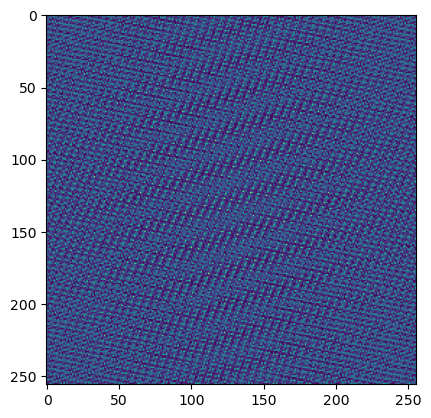

In [ ]:
sky_im

imageds = (np.abs(sky_im.detach().numpy()))
plt.imshow(imageds)
plt.show()

In [ ]:

optimizer = optim.SGD([x1, y1, x2, y2, x3, y3, x4, y4], lr=1)

steps = 500

loss_history = []





its=100

loss_history=[]

for step in range(steps):

    sky = torch.zeros((width, width), dtype=torch.complex64)
    sky[width//2, width//2]=1

    



    baselines = [
        [ant_pos[0][0] - ant_pos[1][0], ant_pos[0][1] - ant_pos[1][1]],
        [ant_pos[0][0] - ant_pos[2][0], ant_pos[0][1] - ant_pos[2][1]],
        [ant_pos[0][0] - ant_pos[3][0], ant_pos[0][1] - ant_pos[3][1]],
        [ant_pos[1][0] - ant_pos[0][0], ant_pos[1][1] - ant_pos[0][1]],
        [ant_pos[1][0] - ant_pos[2][0], ant_pos[1][1] - ant_pos[2][1]],
        [ant_pos[1][0] - ant_pos[3][0], ant_pos[1][1] - ant_pos[3][1]],
        [ant_pos[2][0] - ant_pos[0][0], ant_pos[2][1] - ant_pos[0][1]],
        [ant_pos[2][0] - ant_pos[1][0], ant_pos[2][1] - ant_pos[1][1]],
        [ant_pos[2][0] - ant_pos[3][0], ant_pos[2][1] - ant_pos[3][1]],
        [ant_pos[3][0] - ant_pos[0][0], ant_pos[3][1] - ant_pos[0][1]],
        [ant_pos[3][0] - ant_pos[1][0], ant_pos[3][1] - ant_pos[1][1]],
        [ant_pos[3][0] - ant_pos[2][0], ant_pos[3][1] - ant_pos[2][1]],
    ]

    u_indices = [
        int((baselines[0][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][0] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][0] + max_baseline) * width / (2 * max_baseline)),
    ]

    v_indices = [
        int((baselines[0][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[1][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[2][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[3][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[4][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[5][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[6][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[7][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[8][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[9][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[10][1] + max_baseline) * width / (2 * max_baseline)),
        int((baselines[11][1] + max_baseline) * width / (2 * max_baseline)),
    ]


    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=True)
    # Creating a new tensor instead of in-place modification
    uv = uv.clone()
    #u_index = 5  # Example index
    #v_index = 5  # Example index

    if 0 <= u_indices < width and 0 <= v_indices < width:
        new_uv = uv.clone()  # Create a new tensor to avoid in-place modification
        new_uv[u_indices, v_indices] = 1
        
    sky_image = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(new_uv)))

    radius = 1  # Radius of the circular mask

    # Create a circular mask
    mask = torch.zeros((width, width), dtype=torch.bool, )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= radius**2

    masked_uv = sky_image * mask
    outofmask=sky_image-masked_uv

    nt_ratio=(torch.abs(torch.sum(torch.abs(outofmask))))/(torch.abs(torch.sum(torch.abs(masked_uv))))
    ratio.append(nt_ratio)

    
    loss = nt_ratio
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Compute gradients
    loss.backward()
    #retain_graph=True

    # Update parameters
    optimizer.step()

    loss_history.append(loss.item())

    if step % 100 == 0:
        print(f'Step {step}: loss_history = {loss.item()}') # Prints a value for loss function once every hundred iterations

    
    



TypeError: optimizer can only optimize Tensors, but one of the params is float